###  [House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)
### by 《网易云课程 x 稀牛学院 机器学习工程师微专业》寒小阳

### 目录：   
* 1 - 方案概述  
* 2 - 数据探索   
* 3 - 数据处理   
* 4 - 特征工程   
* 5 - 模型选择   
* 6 - 模型融合  
* 7 - 提交结果  
* 8 - 项目总结  
* 9 - 参考文献

### 0.问题背景
#### by 《网易云课程 x 稀牛学院 机器学习工程师微专业》寒小阳
![](./house_price_regression.png)

### 1. 方案概述：
#### by 《网易云课程 x 稀牛学院 机器学习工程师微专业》寒小阳
&emsp;&emsp;本次竞赛中，数据集通过79个特征变量来描述爱荷华州埃姆斯的住宅房屋的各个方面，需要预测每个住宅的最终价格，并提交预测结果。问题转化成回归问题，评估指标为均方根误差(RMSE)。    
&emsp;&emsp;本文首先从数据探索开始，我们拿到数据后先要对数据集size以及有哪些特征等信息有个大致了解；然后进行数据处理，介绍我们对离群点的剔除方法以及对目标值的平滑化处理方法；其次进行特征工程，包括对缺失值的多维度处理、组合特征构建、Embedded方法进行特征选择以及类别特征编码等；之后进行模型选择与设计，使用网格搜索交叉验证找到最佳候选超参数和模型，使用early stopping方法选择最佳boosting轮数；最后介绍了模型融合方法，我们采用了多种常用的回归技术以及数据挖掘比赛大杀器xgboost和lightgbm，对几种单一的回归模型采用stacking方法堆叠成一个混合模型，再通过反复的实验和试错确定最终的平均权重与其他模型进行简单的Ensemble。最终的线上得分是0.10964。   

### 2. 数据探索：
#### by 《网易云课程 x 稀牛学院 机器学习工程师微专业》寒小阳
&emsp;&emsp;我们拿到数据后，先对数据要有个大致的了解：我们有1460的训练数据和1459的测试数据，数据的特征列有79个，其中35个是数值类型的，44个类别类型。

- 导入一些必要的库和数据：

In [1]:
import numpy as np 
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn


from scipy import stats
from scipy.stats import norm, skew


pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output

In [2]:
train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [4]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000,1460.000,1201.000,1460.000,1460.000,1460.000,1460.000,1460.000,1452.000,1460.000,...,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000
mean,730.500,56.897,70.050,10516.828,6.099,5.575,1971.268,1984.866,103.685,443.640,...,94.245,46.660,21.954,3.410,15.061,2.759,43.489,6.322,2007.816,180921.196
std,421.610,42.301,24.285,9981.265,1.383,1.113,30.203,20.645,181.066,456.098,...,125.339,66.256,61.119,29.317,55.757,40.177,496.123,2.704,1.328,79442.503
min,1.000,20.000,21.000,1300.000,1.000,1.000,1872.000,1950.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,2006.000,34900.000
25%,365.750,20.000,59.000,7553.500,5.000,5.000,1954.000,1967.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5.000,2007.000,129975.000
50%,730.500,50.000,69.000,9478.500,6.000,5.000,1973.000,1994.000,0.000,383.500,...,0.000,25.000,0.000,0.000,0.000,0.000,0.000,6.000,2008.000,163000.000
75%,1095.250,70.000,80.000,11601.500,7.000,6.000,2000.000,2004.000,166.000,712.250,...,168.000,68.000,0.000,0.000,0.000,0.000,0.000,8.000,2009.000,214000.000
max,1460.000,190.000,313.000,215245.000,10.000,9.000,2010.000,2010.000,1600.000,5644.000,...,857.000,547.000,552.000,508.000,480.000,738.000,15500.000,12.000,2010.000,755000.000


- ID特征对分类没有影响，但最后我们得到结果以后提交的时候需要，所以需要将ID单独提取出来：

In [4]:
# 检查数据维度
print("训练集丢弃ID特征前的size：",train.shape)
print("测试集丢弃ID特征前的size：",test.shape)

# 单独保存ID列
train_ID = train['Id']
test_ID = test['Id']

# 去掉ID列
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

# 检查数据维度
print("\n训练集丢弃ID特征后的size：",train.shape) 
print("测试集丢弃ID特征后的size：",test.shape)

训练集丢弃ID特征前的size： (1460, 81)
测试集丢弃ID特征前的size： (1459, 80)

训练集丢弃ID特征后的size： (1460, 80)
测试集丢弃ID特征后的size： (1459, 79)


### 3. 数据处理
#### by 《网易云课程 x 稀牛学院 机器学习工程师微专业》寒小阳

- 离群点处理：  
  - 当然数据探索部分并没有结束，在数据处理部分，我们会边探索边处理：  
    在数据中会有个别离群点，他们对分类结果噪音太大，我们选择将其删掉。但是如果不是太过分的离群点，就不能删掉，因为如果删掉所有噪声会影响模型的健壮性，对测试数据的泛化能力就会下降。

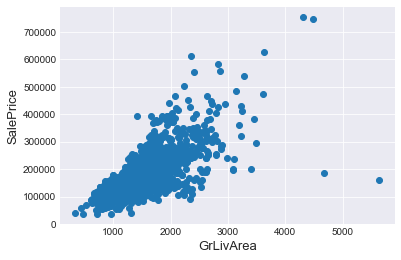

In [5]:
# 绘图
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

- 从上面的散点图可看出：右下方的两个数据，living area特别大，但是价格又低的离谱，应该是远离市区的无人地带。对最后的分类结果没有影响的离群点（Oultliers），我们可以放心将其删除。

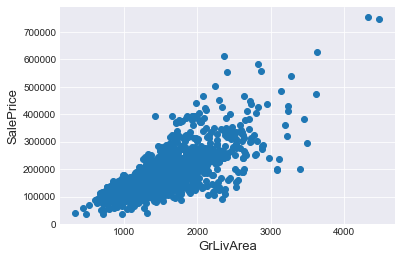

In [6]:
# 删除离群点
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

# 绘图
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

- 目标值处理：
  - 线性的模型需要正态分布的目标值才能发挥最大的作用。我们需要检测房价什么时候偏离正态分布。使用probplot函数，即正态概率图：


 mu = 180932.92 and sigma = 79467.79



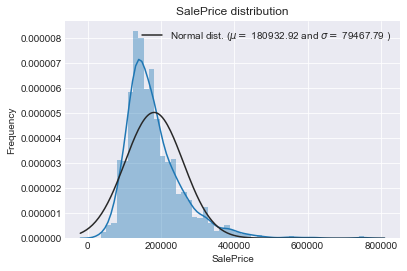

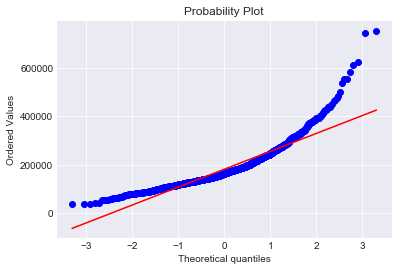

In [7]:
sns.distplot(train['SalePrice'] , fit=norm)
# 正态分布拟合
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# 绘图
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

# 原始数据分布绘图
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

- 此时的正态分布属于右偏态分布，即整体峰值向左偏离，并且偏度(skewness)较大，需要对目标值做log转换，以恢复目标值的正态性。


 mu = 12.02 and sigma = 0.40



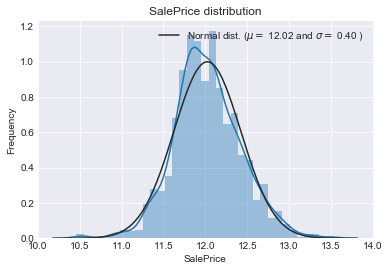

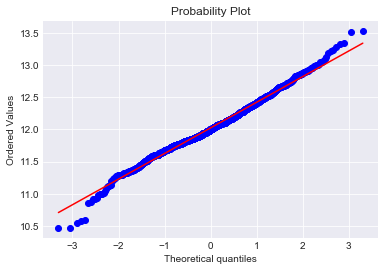

In [8]:
# 使用log1p函数完成log(1+x)变换
train["SalePrice"] = np.log1p(train["SalePrice"])

# 查看调整后的分布
sns.distplot(train['SalePrice'] , fit=norm);

# 重新拟合
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# 重新绘制正态分布
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

# 绘制变换后的分布
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

### 4. 特征工程：
#### by 《网易云课程 x 稀牛学院 机器学习工程师微专业》寒小阳
&emsp;&emsp;为了方便处理数据，我们将训练集和测试集先进行合并

In [9]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("合并后数据集的size：",all_data.shape)

合并后数据集的size： (2917, 79)


&emsp;&emsp;缺失数据可视化：

Text(0.5,1,'Percent missing data by feature')

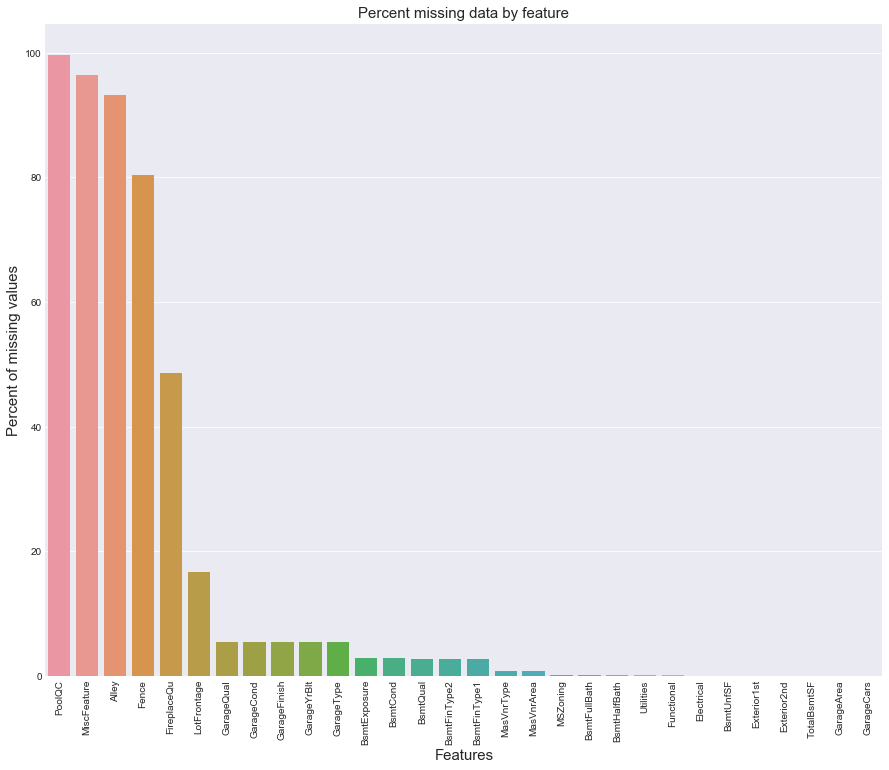

In [10]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})

f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

&emsp;&emsp;分析各个特征与房价的相关性，相关性的分析最好使用热力图：

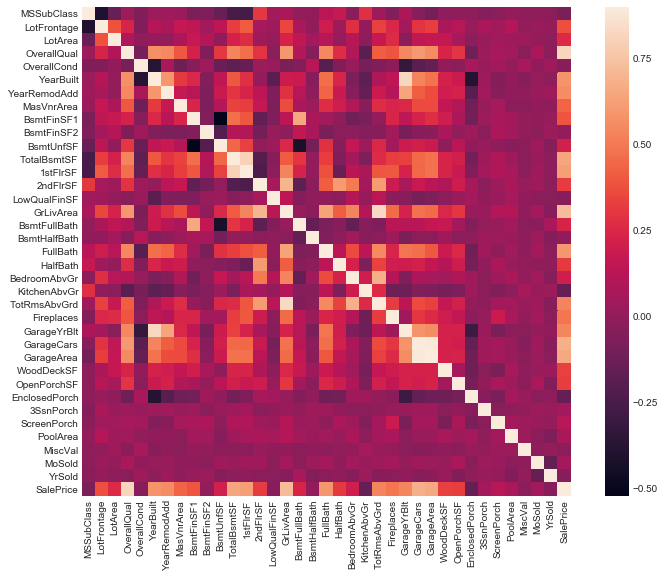

In [11]:
# 绘制热力图去查看特征相关性
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

&emsp;&emsp;可以看到对角线有一条白线，这代表相同的特征相关性为最高，但值得注意的是，有两个正方形小块：TotaLBsmtSF和1stFlrSF、GarageAreas和GarageCars处。这代表全部建筑面积TotaLBsmtSF与一层建筑面积1stFlrSF成强正相关，车库区域GarageAreas和车库车辆GarageCars成强正相关，那么在填补缺失值的时候就有了依据，我们可以直接删掉一个多余的特征或者使用一个填补另一个。

填补缺失值： 

In [12]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')
    
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)
    
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)
    
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')
    
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

#对于'Utilities'这个特征，所有记录均为“AllPub”，除了一个“NoSeWa”和2个NA。 由于拥有'NoSewa'的房子在训练集中，
#因此此特征对预测建模无助。 然后我们可以安全地删除它。
all_data = all_data.drop(['Utilities'], axis=1)

all_data["Functional"] = all_data["Functional"].fillna("Typ")
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


更多的数据工程：

1、有许多特征实际上是类别型的特征，但给出来的是数字。比如MSSubClass，是评价房子种类的一个特征，给出的是10-100的数字，但实际上是类别，所以我们需要将其转化为字符串类别。

In [13]:
# MSSubClass是房子种类
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

# 同样对OverallCond做变换
all_data['OverallCond'] = all_data['OverallCond'].astype(str)

# 年与月份
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

2、接下来 LabelEncoder，对部分类别的特征进行编号。

In [14]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

# 使用LabelEncoder做变换
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# 查看维度        
print('all_data的数据维度: {}'.format(all_data.shape))

all_data的数据维度: (2917, 78)


3、接下来添加一个重要的特征，因为我们实际在购买房子的时候会考虑总面积的大小，但是此数据集中并没有包含此数据。总面积等于地下室面积+1层面积+2层面积。

In [15]:
# 添加总面积特征
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

4、我们对房价进行分析，不符合正态分布的我们将其log转换，使其符合正态分布。那么偏离正态分布太多的特征我们也对它进行转化：

In [16]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# 对所有数值型的特征都计算skew，计算一下偏度
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head()


Skew in numerical features: 



,Skew
MiscVal,21.940
PoolArea,17.689
LotArea,13.109
LowQualFinSF,12.085
3SsnPorch,11.372


In [17]:
skewness = skewness[abs(skewness) > 0.75]
print("总共有 {} 数值型的特征做变换".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)

总共有 59 数值型的特征做变换


5、将类别特征进行哑变量转化：

In [18]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2917, 220)


6、获得新的训练和测试集。至此，我们的特征工程已经处理完毕。

In [19]:
train = all_data[:ntrain]
test = all_data[ntrain:]

### 5. 模型选择
#### by 《网易云课程 x 稀牛学院 机器学习工程师微专业》寒小阳
导入库：

In [20]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

&emsp;&emsp;我们使用Sklearn的cross_val_score函数。然而这个函数没有shuffle方法，我们添加了一行代码，为了在交叉验证之前shuffle数据集。

In [21]:
# 交叉验证函数
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

Score的方法为MSE，建立几个基模型：  
1、LASSO Regression :
  - 该模型可能对异常值非常敏感。 所以我们需要让它更加健壮。 为此，我们在pipeline上使用sklearn的Robustscaler()方法

In [22]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

2、Elastic Net Regression :  
- 同样让它对异常值具有鲁棒性

In [23]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

3、Kernel Ridge Regression :

In [24]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

4、Gradient Boosting Regression :
- 由于Huber loss使得它对于异常值具有鲁棒性

In [25]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

5、XGBoost :

In [26]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

6、LightGBM :

In [27]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

&emsp;&emsp;我们来看一下各个模型交叉验证的得分：

In [28]:
score = rmsle_cv(lasso)
print("\nLasso 得分: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso 得分: 0.1115 (0.0074)



In [29]:
score = rmsle_cv(ENet)
print("ElasticNet 得分: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet 得分: 0.1116 (0.0074)



In [30]:
score = rmsle_cv(KRR)
print("Kernel Ridge 得分: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge 得分: 0.1153 (0.0075)



In [31]:
score = rmsle_cv(GBoost)
print("Gradient Boosting 得分: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting 得分: 0.1177 (0.0080)



In [32]:
score = rmsle_cv(model_xgb)
print("Xgboost 得分: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost 得分: 0.1161 (0.0079)



In [33]:
score = rmsle_cv(model_lgb)
print("LGBM 得分: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

LGBM 得分: 0.1154 (0.0071)



### 6. 模型融合
#### by 《网易云课程 x 稀牛学院 机器学习工程师微专业》寒小阳
&emsp;&emsp;Stacking模型融合：Average-Stacking  
&emsp;&emsp;我们从简单的平均基本模型的方法开始。 我们构建了一个新类来扩展scikit-learn和模型，并且还利用封装与代码重用（继承）

In [34]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # 遍历所有模型，你和数据
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        for model in self.models_:
            model.fit(X, y)

        return self
    
    # 预估，并对预估结果值做average
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

&emsp;&emsp;平均四个模型ENet，GBoost，KRR和lasso。利用上面重写的方法，我们可以轻松地添加更多的模型：

In [35]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print(" 对基模型集成后的得分: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 对基模型集成后的得分: 0.1091 (0.0075)



可以看到，均方误差比单独使用几个模型有所下降，这还是最简单的模型融合，这鼓励我们向着更深的模型融合的方向继续努力。

Meta-model Stacking：  
在这种方法中，我们在平均基础模型上添加Meta-model，并使用这些基模型的out-of-folds预测来训练我们的Meta-model。  
训练部分的步骤如下：  
1、将整个训练集分解成两个不相交的集合（这里是train和.holdout）。   
2、在第一部分（train）上训练几个基本模型。   
3、在第二个部分（holdout）上测试这些基本模型。   
4、使用(3)中的预测（称为 out-of-fold 预测）作为输入，并将正确的标签（目标变量）作为输出来训练更高层次的学习模型称为元模型。   
前三个步骤是迭代完成的。例如，如果我们采取5倍的fold，我们首先将训练数据分成5次。然后我们会做5次迭代。在每次迭代中，我们训练每个基础模型4倍，并预测剩余的fold（holdout fold）。

构建了一个Stacking averaged Models的类：

In [36]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # 遍历拟合原始模型
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # 得到基模型，并用基模型对out_of_fold做预估，为学习stacking的第2层做数据准备
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # 学习stacking模型
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    # 做stacking预估
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

测试Meta-model Stacking结果：

In [37]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1085 (0.0074)


添加元学习器后，我们得到了一个更好的结果！  
然后为了得到最后提交的结果，我们将StackedRegressor、XGBoost和LightGBM进行融合，得到rmsle的结果。

In [38]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

最终的训练和预测：

In [39]:
#StackedRegressor:
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y_train, stacked_train_pred))

0.07815719379163726


In [40]:
#XGBoost:
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y_train, xgb_train_pred))

0.0785165142425036


In [41]:
#LightGBM:
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(rmsle(y_train, lgb_train_pred))

0.07247823724376089


In [45]:
'''RMSE on the entire Train data when averaging'''

print('训练集上的RMSLE得分:')
print(rmsle(y_train,stacked_train_pred*0.72 +
               xgb_train_pred*0.14  + lgb_train_pred*0.14 ))

训练集上的RMSLE得分:
0.07547841488242242


将三者进行融合，然后得到Ensemble prediction：

In [48]:
ensemble = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15

得到待提交的CSV文件：

In [49]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = ensemble
sub.to_csv('submission.csv',index=False)

### 7. 摸爬滚打提交结果
#### by 《网易云课程 x 稀牛学院 机器学习工程师微专业》寒小阳

提交了数次，摸爬滚打简单刷了一下。

做了一些额外的优化，包括：  
①原先对缺失值的填充，类别型是用None来填充，数值型用0来填充。现在对于缺失较少(<5\)的几个特征，类别型改用众数填充，数值型改用中位数填充；  
②添加了部分组合特征；  
③异常值处理，有些值显然是错误的，这可能会影响我们的模型。 我用最小值和最大值来检查数据中的比较奇怪的值。比如GarageYrBlt(车库建造年份)特征,最大值为2207，这显然是错误的，因为数据都是2010年之前，经过分析发现最有可能是数据输入错误，我们假设是2007年；  
④删掉不平衡特征，比如utilities特征中AllPub类别占了97%以上，区分度不大，删掉utilities特征； <br>
⑤用Embedded方法进行特征筛选，剔掉特征重要度为0的特征；    
⑥模型融合，剔除效果最差的GBR，其他模型进行网格搜索交叉验证调参，将最终的集成模型与LASSO、ElasticNet、Ridge、xgboost以及lightgbm进行简单的Ensemble。

成绩榜单变化如下：

#### 第一次
![第一次](http://7xo0y8.com1.z0.glb.clouddn.com/kaggle_house_price/first_sub.png)
#### 特征处理与模型集成
![](http://7xo0y8.com1.z0.glb.clouddn.com/kaggle_house_price/second_sub.png)
#### 多模型再集成
![](http://7xo0y8.com1.z0.glb.clouddn.com/kaggle_house_price/fifth_sub.png)

### 8. 项目总结
#### by 《网易云课程 x 稀牛学院 机器学习工程师微专业》寒小阳

&emsp;&emsp;这是一个非常典型的回归类问题建模过程，包含数据预处理、特征工程、机器学习模型调优(交叉验证)、模型融合(bagging与stacking思想)等环节。整个建模过程提醒我们，如果希望数据驱动的解决方案取得好的结果，需要对解决的问题理解足够得好，结合场景做合适的数据处理(降噪)，并得到有效的特征(对数值型、类别型、文本型等不同的数据不同的处理)，再充分利用多模型的优点集成，降低模型的过拟合程度，得到更有泛化能力的预测模型。

### 9. 参考文献：
#### by 《网易云课程 x 稀牛学院 机器学习工程师微专业》寒小阳
[Stacked Regressions : Top 4% on LeaderBoard](https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard)  
[Top 2% of LeaderBoard - Advanced FE](https://www.kaggle.com/laurenstc/top-2-of-leaderboard-advanced-fe)